<a href="https://colab.research.google.com/github/Diwakar-Gupta/DataScience/blob/main/Deep_Dream/Dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[blog](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)

[tutorial](https://www.tensorflow.org/tutorials/generative/deepdream)

https://youtu.be/BsSmBPmPeYQ

DeepDream is an experiment that visualizes the patterns learned by a neural network. Similar to when a child watches clouds and tries to interpret random shapes, DeepDream over-interprets and enhances the patterns it sees in an image.

In [ ]:
import tensorflow as tf

import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Choose an image to dream-ify

In [ ]:
# url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
# url = 'https://images.unsplash.com/photo-1580243117731-a108c2953e2c?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8bm9pc2V8ZW58MHx8MHx8&w=1000&q=80'
url = 'https://media.istockphoto.com/photos/picturesque-morning-in-plitvice-national-park-colorful-spring-scene-picture-id1093110112?k=20&m=1093110112&s=612x612&w=0&h=3OhKOpvzOSJgwThQmGhshfOnZTvMExZX2R91jNNStBY='

106496/97768 [================================] - 0s 0us/step
original shape:  (333, 500, 3) uint8


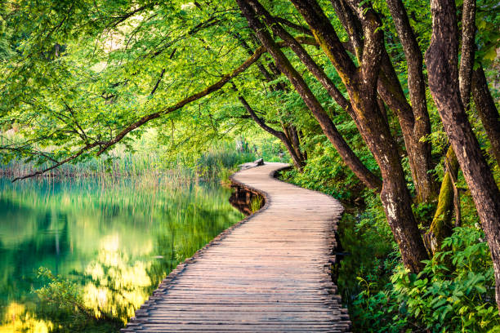

Reshaped to:  (412, 500, 3) uint8


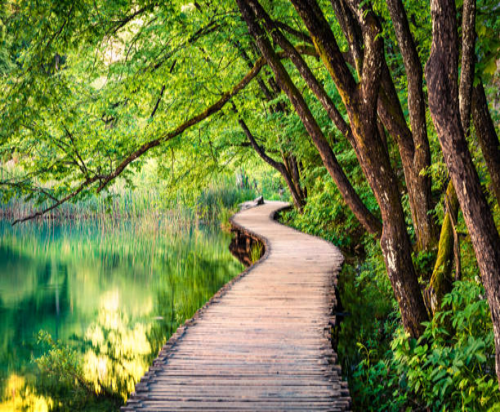

In [ ]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim :
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

# Normalize Image
def deprocess(img):
    # img = img-tf.reduce_min(img)
    # img = (img/tf.reduce_max(img))*127
    img = 255*(img+1)/2
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
print('original shape: ', original_img.shape, original_img.dtype)
show(original_img)
original_img = tf.image.resize(original_img, (412, 500)).numpy()
original_img = original_img.astype(np.uint8)
print('Reshaped to: ', original_img.shape, original_img.dtype)
show(original_img)

# Prepare the feature extraction model

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 0s 0us/step


The idea in DeepDream is to choose a layer (or layers) and maximize the "loss" in a way that the image increasingly "excites" the layers.

Deeper layers respond to higher-level features (such as eyes and faces), while earlier layers respond to simpler features (such as edges, shapes, and textures). 

In [ ]:
# Maximize the activations of these layers
names = ['mixed2', 'mixed3']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

# Calculate loss

Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.



In [ ]:
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
    
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    
    return tf.reduce_sum(losses)

In [ ]:
img = original_img.copy()

img = tf.keras.applications.inception_v3.preprocess_input(img)
# img = deprocess(img)
# img = tf.convert_to_tensor(img)

In [ ]:
tf.reduce_min(img), tf.reduce_max(img)

(<tf.Tensor: shape=(), dtype=float32, numpy=-1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [ ]:
loss = dream_model(tf.expand_dims(img, axis=0))

In [ ]:
tf.math.reduce_mean(loss[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.3041509>

# Gradient ascent

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)
        # print(type(loss))
        # loss = calc_loss(img, self.model)
        # print(type(loss))
        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

# Main Loop

In [ ]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

In [ ]:
# dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)

# Taking it up an octave

There are a few issues

*   The output is noisy.
*   The image is low resolution.
*   The patterns appear like they're all happening at the same granularity.


One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.




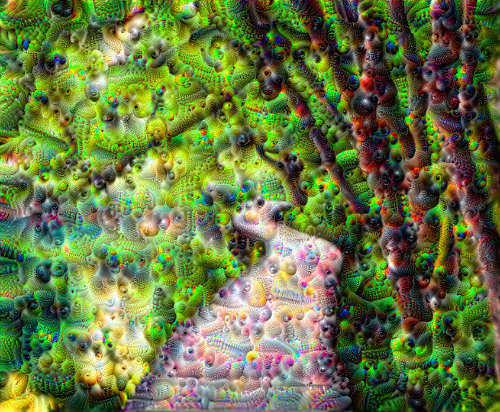

262.2600293159485

In [ ]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start